# Setup DB connection

In [2]:
import os
import math
import string
import numpy as np
import editdistance
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
DB_HOST = {'course': os.environ['COURSE_DB_HOST'], 'app': os.environ['APP_DB_HOST']}
DB_PORT = {'course': os.environ['COURSE_DB_PORT'], 'app': os.environ['APP_DB_PORT']}
DB_NAME = {'course': os.environ['COURSE_DB_NAME'], 'app': os.environ['APP_DB_NAME']}
DB_USER = {'course': os.environ['COURSE_DB_USER'], 'app': os.environ['APP_DB_USER']}
DB_PASS = {'course': os.environ['COURSE_DB_PASSWORD'], 'app': os.environ['APP_DB_PASSWORD']}

In [6]:
import psycopg2

course_connection = psycopg2.connect(host=DB_HOST['course'], port=int(DB_PORT['course']), dbname=DB_NAME['course'], user=DB_USER['course'], password=DB_PASS['course'])
app_connection = psycopg2.connect(host=DB_HOST['app'], port=int(DB_PORT['app']), dbname=DB_NAME['app'], user=DB_USER['app'], password=DB_PASS['app'])
course_cursor = course_connection.cursor()
app_cursor = app_connection.cursor()

# Data analysis

## Courses

Table columns:
	 0 365
	 1 Principles of Evolutionary Medicine
	 2 BIOL
	 3 48
	 4 None
	 5 http://dartmouth.smartcatalogiq.com/en/2015/orc/Departments-Programs-Undergraduate/Biological-Sciences/BIOL-Biological-Sciences-Undergraduate/BIOL-48
	 6 ORC
	 7 2016-02-09 08:14:43.727876+00:00
	 8 2016-02-09 08:17:32.202661+00:00
	 9 0
	 10 0
	 11 This course considers human health and disease from the perspective of evolutionary biology.  Topics will include adaptive explanations for the life history traits, the evolution of nutrition metabolism, host-pathogen co-evolution, models of disease dynamics and the ecology of disease, the evolution of sexual reproduction and sexual dimorphism, and the evolution of altruism.


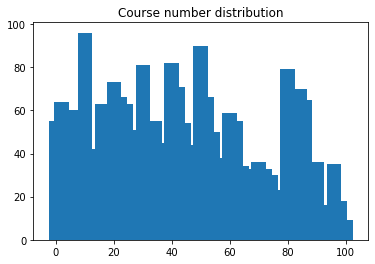

In [4]:
course_cursor.execute('SELECT * FROM web_course;')
courses = course_cursor.fetchall()

print('Table columns:')
for idx, item in enumerate(courses[385]):
    print('\t', idx, item)

buckets = dict()
factor = 2
for i in [factor * i for i in range(math.ceil(100 / factor) + 1)]:
    buckets[i] = 0
for course in courses:
    number = course[3]
    if number <= 100:
        buckets[(number // factor) * factor] += 1

plt.title('Course number distribution')
plt.bar(buckets.keys(), buckets.values(), width=5)
plt.show()

## Professors

In [7]:
app_cursor.execute('SELECT * FROM web_review;')
reviews = np.array(app_cursor.fetchall())
app_cursor.execute('SELECT * FROM web_course;')
courses_raw = np.array(app_cursor.fetchall())

In [10]:
courses = dict()

for course in courses_raw:
    if course[0] in courses:
        print('Duplicate error', course[0])
    else:
        courses[course[0]] = course

depts = dict()

for review in reviews:
    course_key = review[6]
    term = review[2]
    course = courses[course_key]
    dept = course[2]
    if dept in depts:
        if course_key in depts[dept]:
            if term in depts[dept][course_key]:
                depts[dept][course_key][term].append(review)
            else:
                depts[dept][course_key][term] = [review]
        else:
            depts[dept][course_key] = {term: [review]}
    else:
        depts[dept] = {course_key: {term: [review]}}

In [13]:
missing_info = []

In [67]:
def analyze_name(name):
    analysis = {'raw': name.lower().strip(), 'split': name.lower().strip().split(' '), 'first': None, 'first_initial': None, 'last': None, 'last_initial': None}
    if len(analysis['split']) > 1:
        analysis['first'] = analysis['split'][0]
        analysis['first_initial'] = analysis['first'][0]
        if len(analysis['first']) == 2 and '.' in analysis['first']:
            analysis['first'] = None
        if (len(analysis['split'])) > 2:
            analysis['last'] = ' '.join(analysis['split'][1:])
            analysis['last_initial'] = analysis['last'][0]
            analysis['more_than_two'] = True
        else:
            analysis['last'] = analysis['split'][1]
            analysis['last_initial'] = analysis['last'][0]
            if len(analysis['last']) == 2 and '.' in analysis['last']:
                analysis['last'] = None
    else:
        analysis['cannot_break_down'] = True
    return analysis

def close_enough(str1, str2):
    if editdistance.eval(str1, str2) < 3:
        # print(str1)
        # print(str2)
        return True
    else: return False

def check_match(name1, name2):
    a = analyze_name(name1)
    b = analyze_name(name2)
    if a['raw'] != b['raw']:
        if not a['first_initial']:
            return 'missing_info_a'
        elif not b['last_initial']:
            return 'missing_info_b'
        elif a['first_initial'] == b['first_initial'] and a['last_initial'] == b['last_initial']:
            if a['first'] and b['first']:
                if a['first'][:2] == b['first'][:2]:
                    return 'check'
                else: return 'unsure'
            if a['last'] and b['last']:
                if a['last'][:2] == b['last'][:2]:
                    return 'unsure'
                else: return 'pass'
            else:
                return 'check'
        else:
            return 'pass'
    else:
        return 'pass'

In [142]:
examine = dict()
unsure = dict()

def process_decision(decision, a, b):
    if decision == 'missing_info_a':
        missing_info.append(a)
    elif decision == 'missing_info_b':
        missing_info.append(b)
    elif decision == 'pass':
        pass
    elif decision == 'check':
        if a[0] in examine: examine[a[0]].append(b)
        else: examine[a[0]] = [b]
    elif decision == 'unsure':
        if a[0] in unsure: unsure[a[0]].append(b)
        else: unsure[a[0]] = [b]

for dept in depts.keys():
    reviews_for_dept = []
    for course in depts[dept].keys():
        for term in depts[dept][course]:
            reviews_for_dept.extend(depts[dept][course][term])
            # reviews_for_term = depts[dept][course][term]
            # for i in range(len(reviews_for_term)):
            #     for j in range(i, len(reviews_for_term)):
            #         decision = check_match(reviews_for_term[i][1], reviews_for_term[j][1])
    for i in range(len(reviews_for_dept)):
        for j in range(i, len(reviews_for_dept)):
            decision = check_match(reviews_for_dept[i][1], reviews_for_dept[j][1])
            process_decision(decision, reviews_for_dept[i], reviews_for_dept[j])

print('Examining: ', len(examine))
print('Unsure: ', len(unsure))
print('Missing info: ', len(missing_info))

y'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'nump

In [155]:
missing_info_filter = list(filter(lambda x: type(x) != str, missing_info))
print(len(missing_info_filter))
tr = (np.transpose(np.array(missing_info_filter)))
print(tr[0])
# for e in examine.items():
#     print(e[0])
#     for p in e[1]:
#         print('\t', p[0])

14427
[95 95 95 ... 23595 23595 23595]


In [152]:
np.savetxt('examine.txt', list(map(lambda x: str([x[0]].extend(list(map(lambda y: y[0], x[1])))), examine.items())), fmt='%s')
# np.savetxt('unsure.txt', list(map(lambda x: str([x[0]].extend(x[1][0])), unsure.items())), fmt='%s')
np.savetxt('missing_info.txt', list(map(lambda x: x[0], missing_info_filter)), fmt='%s')

In [130]:
for review in reviews:
    if type(review) != np.ndarray:
        print(review)
# print(type(reviews[0]))